In [2]:
import keras

In [3]:
# Importing the data
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [4]:
# Because the features are all with different scales, we do feature-wise
# normalisation
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std
# Note that we also normalise the test data using mean and std calculated on the 
# training dataset

In [5]:
# We have little data in this case, so we use a small network to mitigate overfitting
from keras import models
from keras import layers

# We use a function in this case because later we want to instantiate this model several times
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [12]:
# Also due to the small amount of data, we want to use k-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [16]:
for i in range(k):
    print('Processing fold #', i)
    # Get the validatation set for this iteration
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Get the training set for this iteration
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    # Now we can build the keras model using the function we defined above - this already compiles it
    model = build_model()
    # Then we train it (in silent mode)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [19]:
print(all_scores)
np.mean(all_scores)

[2.0750808349930412, 2.117215852926273, 2.9140411863232605, 2.4288365227161068]


2.3837935992396706

In [20]:
# Now, to check how the model performs as it trains, we will keep a record of its performance
# at each epoch
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


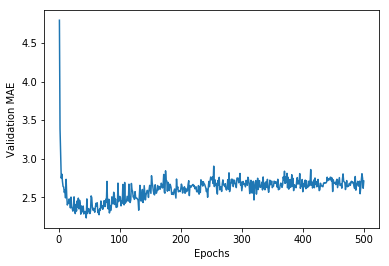

In [25]:
# We can now calculate the average per-epoch MAE for all the folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# and then we can plot it
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

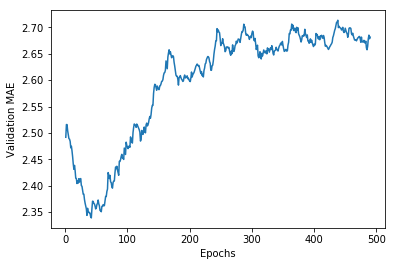

In [26]:
# The plot is a bit hard to see due to scaling issues
# We exclude the first data points and also smooth the curve
# by replacing each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])


plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# We can see that the model starts overfitting after about 80 epochs
                

In [27]:
# Based on the results of the cross-validation, we choose 80 epochs
# as the optimal training period
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
# Test_mae_score
test_mae_score

102/102 [==============================] - 0s 516us/step


2.6851863861083984